In [1]:
# Download from https://github.com/evogytis/baltic/tree/master/baltic
# put the *.py in the package_library folder of whatever python version you use
import baltic as bt
import re
import os
import glob
import sys
import time
import pandas as pd
import numpy as np

from collections import OrderedDict
from scipy.stats import gaussian_kde
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams 
# from matplotlib import style
from matplotlib.colors import ListedColormap # control color in seaborn heatmap
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle


%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)
# style.use('ggplot')

# print rcParams.keys()

C:\Users\xtorrm\Documents\Python3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xtorrm\Documents\Python3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\xtorrm\Documents\Python3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
# spreadsheets with rows representing samples
# to use it with baltic, I have a column with the tree tip names for all samples
ant_annotation=pd.read_csv('./data/Beast_Azteca_traits_20191229.txt',sep='\t')
print(ant_annotation.columns)

Index(['traits', 'site', 'Unnamed: 2'], dtype='object')


In [4]:
# path to tree
ant_tree_path='./data/Azteca_trait_20200113_MCCT.tre'

# loads a nexus file, don't re-scale to absolute time (samples were not collected through time)
ant_tree=bt.loadNexus(ant_tree_path,absoluteTime=False)
# goes through the tree and creates the object
ant_tree.traverse_tree()
# stats about the tree
ant_tree.treeStats()
# creates the tree
ant_tree.drawTree()
# sorts branches 
ant_tree.sortBranches()


Tree height: 63.815810
Tree length: 1238.237484
strictly bifurcating tree
annotations present

Numbers of objects in tree: 811 (405 nodes and 406 leaves)



In [5]:
# creates a list of unique traits present in the tree. In my case, my trait is 'site' and it has 5 states
ant_uniq_traits=[]
for k in ant_tree.Objects:
    # how to print all possible annotations in a tree:
    # print(k.traits.keys())
    # results in:
    # dict_keys(['site.rate', 'length', 'posterior', 'height_median', 'site', 'length_median', 'site.prob',
    # 'height', 'length_range', 'site.set.prob', 'height_range', 'length_95%_HPD', 'height_95%_HPD', 'site.set'])
    # print the trait values if the trait is an annotation of the node, else pass
    # print(k.traits['site'] if 'site' in k.traits else '',k.traits['site.prob'] if 'site.prob' in k.traits else '')
    if 'site' in k.traits:
        if k.traits['site'] in ant_uniq_traits:
            pass
        else:
            ant_uniq_traits.append(k.traits['site'])
ant_uniq_traits

['EastBrasil', 'Australia', 'WestColombia', 'EastColombia', 'CentralAmerica']

In [7]:
# assigns a color to the trait's states and creates a dictionary to access them
# don't pay attention to the extra states.
state_dict={'Australia':'#BCAD00',
            'EastBrasil':'#7E0000',
            'East':'#D73027',
            'EastColombia':'#FF8F58',
            'WestColombia':'#ABD9E7',
            'West':'#558AD1',
            'CentralAmerica':'#313695',
            'Neotropical':'#E9EE10',
            'Montane':'#CD34B5',
            'Caribbean':'#BCAD00'}

In [8]:
# creates a dictionary where the keys are the nodes of the tree and the values are the state of the trait
ant_states={}
for k in ant_tree.Objects:
    if 'site' in k.traits:
        ant_states[k]=k.traits['site']

In [9]:
# the pie is build from three ordered lists (labels,sizes,colors), where the first item of the three lists
# corresponds to the first slice of the pie.

# I create dictionaries to call the three lists to build the pie at every node
# nodes are keys, the lists are valules

# empty dictionary that will store the labels for the pie charts (states of trait)
ant_labels_dict={}
# empty dictionary that will store the sizes of every pie's portion
# in my case the sizes are the posterior probability of every possible state of the trait reconstructed for each node
ant_sizes_dict={}
# will associate states with colors
ant_pie_colors={}
for k in ant_tree.Objects:
    if 'site.set.prob' in k.traits:
        print(k.traits['site.set'],k.traits['site.set.prob'])
        ant_labels_dict[k]=k.traits['site.set']
        ant_sizes_dict[k]=k.traits['site.set.prob']
        ant_pie_colors[k]=[state_dict[x] for x in k.traits['site.set']]

['EastBrasil', 'CentralAmerica', 'Australia', 'WestColombia', 'EastColombia'] [0.5888234640595489, 0.14309521164315075, 0.09943339628930119, 0.13442950783246305, 0.03421842017553605]
['EastBrasil', 'CentralAmerica', 'Australia', 'WestColombia', 'EastColombia'] [0.5662704143984002, 0.08604599488945673, 0.017998000222197535, 0.22619708921230974, 0.10348850127763581]
['EastBrasil', 'CentralAmerica', 'Australia', 'WestColombia', 'EastColombia'] [0.6641484279524498, 0.05732696367070326, 0.0212198644595045, 0.1681479835573825, 0.08915676035996001]
['EastBrasil'] [1.0]
['EastBrasil'] [1.0]
['Australia'] [1.0]
['EastBrasil', 'CentralAmerica', 'Australia', 'WestColombia', 'EastColombia'] [0.017664703921786467, 0.20753249638929008, 0.01060993222975225, 0.7376402621930896, 0.026552605266081546]
['EastBrasil', 'CentralAmerica', 'Australia', 'WestColombia', 'EastColombia'] [0.015664926119320077, 0.4125652705254972, 0.02188645706032663, 0.5317186979224531, 0.018164648372403065]
['EastBrasil', 'Centr

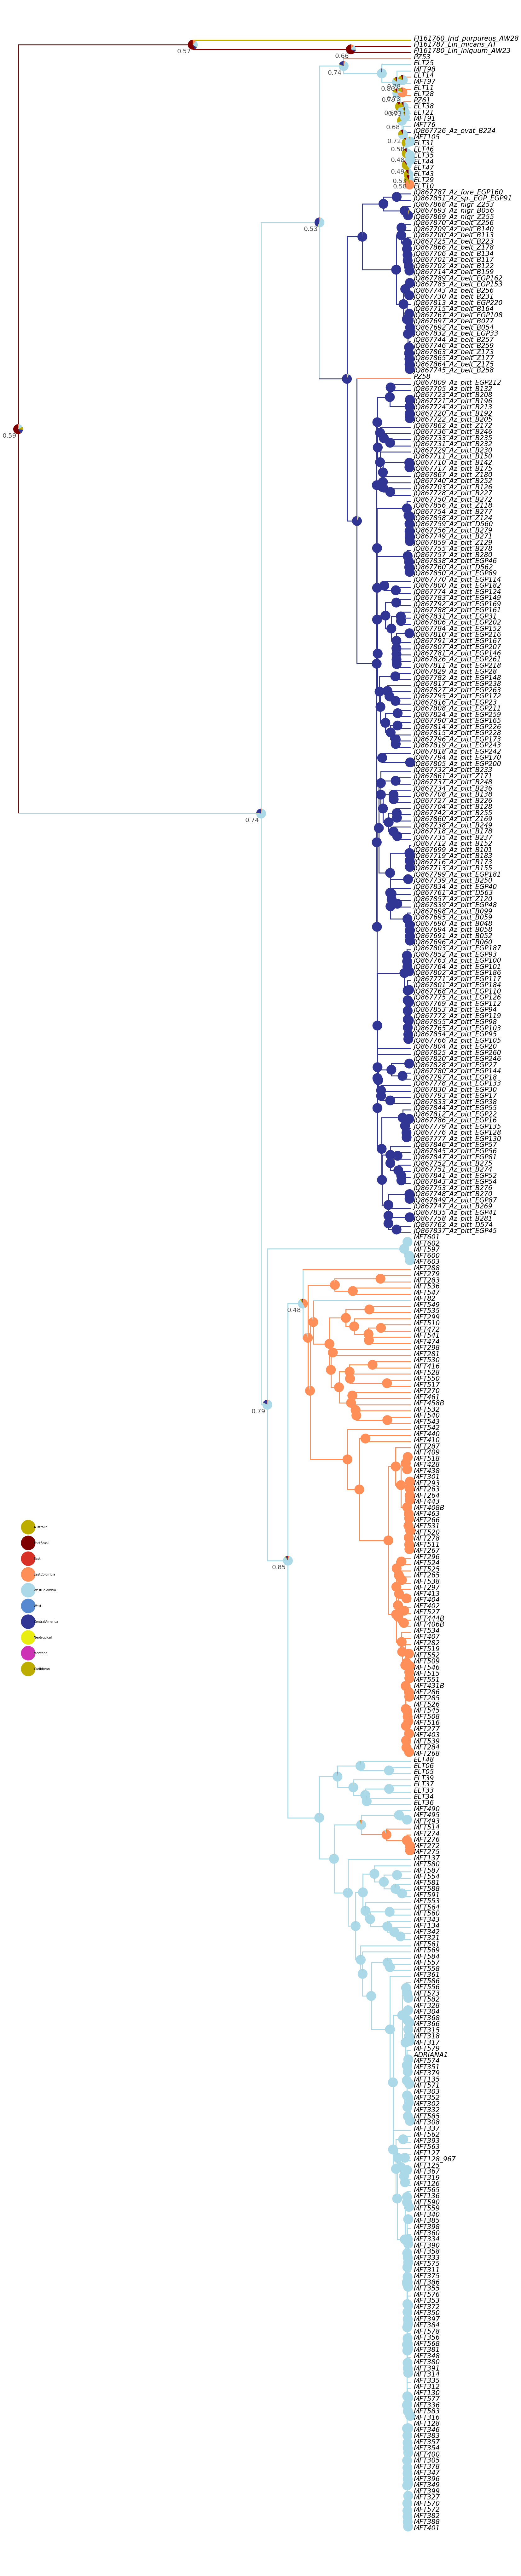

In [11]:
# creates a figure
fig,ax = plt.subplots(figsize=(30,150),facecolor='w')

# defines lambda functions to assign colors
# code from Gytis Dudas (https://github.com/evogytis/baltic)
# labels, legend and the pies' code is mine

x_attr=lambda k: k.height ## x coordinate of branches will be absoluteTime attribute
bc_func=lambda k: state_dict[ant_states[k]] if k in ant_states.keys() else '#B8B6B5' # to colour the tree branches according to the state of the trait
b_func=lambda k: 3 ## branch width function
s_func=lambda k: 200-30*k.height/ant_tree.treeHeight ## size of tips
z_func=lambda k: 100 # zorder, the layer of the figure where the object is plotted.
cu_func=lambda k: 'k' ## for plotting a black outline of tip circles
su_func=lambda k: 2*(600-30*k.height/ant_tree.treeHeight) ## black outline in twice as big as tip circle 
zu_func=lambda k: 99
bw_func=lambda k: 8


for k in ant_tree.Objects:
    # this is the section where the tip information is added
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
            # tip names
            ax.text(k.height+0.5,k.y+0.22,'%s'%(k.name),
                    va='center',ha='left',size=21,color='k',style='italic')
    else:
        # nodes section, prints the posterior of the trait state with the highest probability of the whole set of states (a node can have more than one state)
        # only prints the posterior for values below 0.90 (does not include upper bound)
        if 'site.prob' in k.traits and float(k.traits['site.prob']) <0.89:
            ax.text(k.height-0.3,k.y-0.6,
            '%.2f'%(k.traits['site.prob'] if 'site.prob' in k.traits else ''),
            va='top',ha='right',size=20,color='#545454',zorder=200000)

# sets the plot limits
ax.set_ylim(-6,ant_tree.ySpan+6)

# plots the tree
ant_tree.plotTree(ax,x_attr=x_attr,colour_function=bc_func,branchWidth=b_func) ## plot branches

##### the pies
for k in ant_tree.Objects:
    # if node is not a tip
    if k.branchType!='leaf':
#         # labels=ant_labels_dict[k],center=(k.height,k.y)
        # if pie has values
        if len(ant_sizes_dict[k])>0:
            # plots pie, k.height is the x coordinate of the node, k.y the y coordinate of the node on the tree
            ax.pie(ant_sizes_dict[k],radius=0.8,shadow=False,startangle=90,center=(k.height,k.y),
                  colors=ant_pie_colors[k],wedgeprops={'zorder':100000})

# resets the plot limits because plotting the pies internally messes up with them
ax.set_xlim(-1,ant_tree.treeHeight+1)
ax.set_ylim(-6,ant_tree.ySpan+6)

# creates legend elements
legend_elements=[]
for key,value in state_dict.items():
    legend_elements.append(Line2D([0],[0],marker='o',color=value,label=key,markersize=45))
# play around with the numbers to get it in place
ax.legend(handles=legend_elements, loc='lower left',bbox_to_anchor=(0.025,0.35),labelspacing=4,frameon=False)

plt.xticks([])
plt.yticks([])

[ax.spines[loc].set_visible(False) for loc in ax.spines]

#saves
# plt.savefig('C:/Users/xtorrm/Documents/Ancestral_areas_calibration_2018/Ancestral_areas_calibration_2018/2020/Ant_traits_20200122.png',transparency=False)
plt.show()